## Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
os.chdir('drive/MyDrive/Colab Notebooks/histopathology-cancer-classification')
sys.path.append('src')

In [3]:
!ls

 data
 deep-set-and-gnn.ipynb
 deep-set-end-to-end.ipynb
 deep-set-from-extracted-features.ipynb
 deep-set.ipynb
 deep-set-multiple.ipynb
 feature_extraction.ipynb
 feature_extraction_train.ipynb
 Graph_MIL.ipynb
 model_checkpoint.pt
 README.md
'Sean-testing-Copy of graph-neural-network.ipynb'
 src


In [4]:
# !pip install -q torchinfo

In [5]:
# !pip install -q imbalanced-learn==0.8.0

In [6]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric

In [7]:
import time
import copy
import pickle
import math
import random
from PIL import Image
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import imblearn
from tqdm.notebook import tqdm
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split

from torch_geometric import data
from torch_geometric.nn import GCNConv, SAGPooling, GlobalAttention, global_add_pool, SAGEConv, ChebConv, GraphConv, graclus, global_mean_pool

import torch
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchinfo import summary

## Utility

In [8]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Current device: {:s}".format(device.type))
    return device

In [9]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
def get_wsis_features_labels(root, files):
    all_wsis = []
    all_features = []
    all_labels = []
    for i, f in enumerate(files):
        path = root + '/' + f
        if not os.path.exists(path):
            print("{} does not exist!".format(path))
            continue
        infile = open(path, 'rb')
        raw = pickle.load(infile)
        for wsi, features in raw.items():
            all_wsis.append(wsi)
            all_features.append(list(features.values()))
            all_labels.append(i)
    all_wsis = np.array(all_wsis, dtype=object)
    all_features = np.array(all_features, dtype=object)
    all_labels = np.array(all_labels, dtype=int)
    return all_wsis, all_features, all_labels

In [11]:
def oversample_dataset(wsis, features, labels):
    smote = imblearn.over_sampling.SMOTE(
        # sampling_strategy={0:150, 1:156, 2:20},
        sampling_strategy='auto',
        random_state=seed,
        k_neighbors=3
    )
    indices = np.arange(len(labels))
    indices = np.reshape(indices, (-1, 1))
    indices_sm, labels_sm = smote.fit_resample(indices, labels)
    wsis_sm = wsis[indices_sm.flatten()]
    features_sm = features[indices_sm.flatten()]
    return wsis_sm, features_sm, labels_sm

In [12]:
def shuffle(wsis, features, labels):
    idx = np.random.permutation(len(wsis))
    return wsis[idx], features[idx], labels[idx]

In [13]:
def plot_statistics(measure, values):
    fig = plt.figure(figsize=(10, 5))
    plt.title("Measure: {}".format(measure))
    for label, value in values.items():
        plt.plot(value, label=label)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(measure)
    plt.legend(loc='best')

In [14]:
def plot_cm(labels, preds):
    fig = plt.figure(figsize=(6, 6))
    cm = pd.crosstab(labels, preds,
                     rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True)
    plt.show()

## Global

In [15]:
seed = 647

In [16]:
batch_size = 16

In [17]:
num_patches = 15

In [18]:
in_features = 1024

In [19]:
data_roots = {
    'train' : 'data/train',
    'dev' : 'data/dev'
}

In [20]:
data_files = {
    'train' : ['LUAD_256_features_maxpool.pickle',
               'LUSC_256_features_maxpool.pickle',
               'MESO_256_features_maxpool.pickle'],
    'dev' : ['LUAD_DEV_256_features_maxpool.pickle',
             'LUSC_DEV_256_features_maxpool.pickle',
             'MESO_DEV_256_features_maxpool.pickle']
}

In [21]:
device = get_device()

Current device: cuda


## Data

In [22]:
class HistoDataset(Dataset):
    def __init__(self, wsis, features, labels, num_patches):
        """
        @param wsis: WSI filenames
        @param features: 2D array of features
        @param labels: Labels - {0 : LUAD, 1 : LUSC, 2 : MESO}
        @param num_patches: Number of patches per set to return
        """
        self.wsis = wsis
        self.features = features
        self.labels = labels
        self.num_patches = num_patches
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        wsi, features, label = self.wsis[index], self.features[index], self.labels[index]
        if len(features) == 0:
            raise FileExistsError
        features = self._get_random_features(features)
        input_mask = self._get_input_mask(features)
        input_tensor = self._get_input_tensor(features)
        assert input_mask.shape[0] == self.num_patches
        assert input_tensor.shape[0] == self.num_patches
        return wsi, input_tensor, input_mask, label
    
    def _get_random_features(self, features):
        if len(features) <= self.num_patches:
            return random.sample(features, len(features))
        return random.sample(features, self.num_patches)
    
    def _get_input_mask(self, features):
        num_images = len(features)
        num_empties = self.num_patches - num_images
        return torch.BoolTensor([True] * num_images + [False] * num_empties)
    
    def _get_input_tensor(self, features):
        input_tensor = torch.stack(features, dim = 0)
        P, C = input_tensor.shape
        if P == self.num_patches:
            return input_tensor
        input_tensor_padded = torch.zeros(size=(self.num_patches, C))
        for i in range(P):
            input_tensor_padded[i] = input_tensor[i]
        return input_tensor_padded

### Datasets

In [23]:
def create_dataset(root, files, oversample = True):
    wsis, features, labels = get_wsis_features_labels(root, files)
    if oversample:
        wsis, features, labels = oversample_dataset(wsis, features, labels)
    wsis, features, labels = shuffle(wsis, features, labels)
    dataset = HistoDataset(
        wsis = wsis,
        features = features,
        labels = labels,
        num_patches = num_patches
    )
    return dataset

In [24]:
set_seed(seed)

train_dataset = create_dataset(data_roots['train'], data_files['train'], oversample = True)
dev_dataset = create_dataset(data_roots['dev'], data_files['dev'], oversample = False)

In [25]:
Counter(train_dataset.labels)

Counter({0: 156, 1: 156, 2: 156})

In [26]:
Counter(dev_dataset.labels)

Counter({0: 38, 1: 41, 2: 5})

### Dataloaders

In [27]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = False
)

dev_dataloader = DataLoader(
    dataset = dev_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [28]:
dataloaders = {
    'train' : train_dataloader,
    'dev' : dev_dataloader
}

In [29]:
for dtype, dl in dataloaders.items():
    print("{} has {} batches".format(dtype, len(dl)))

train has 30 batches
dev has 6 batches


### Example

In [30]:
ex_batch = next(iter(train_dataloader))

In [31]:
ex_input_tensors = ex_batch[1].to(device)

In [32]:
ex_input_tensors.shape

torch.Size([16, 15, 1024])

In [33]:
ex_input_masks = ex_batch[2].to(device)

In [34]:
ex_input_masks.shape

torch.Size([16, 15])

In [35]:
ex_labels = ex_batch[3].to(device)

In [36]:
ex_labels.shape

torch.Size([16])

In [37]:
ex_labels

tensor([1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

## Model

### Dense

In [38]:
class Dense(nn.Module):
  def __init__(self):
    super(Dense, self).__init__()
    # self.fc1=nn.Linear(1024, 784)
    # self.fc2=nn.Linear(784, 512)
    self.fc3=nn.Linear(1024, 512)
    # self.d=nn.Dropout(0.5)
  
  def forward(self, x, mask=None):
    # transform mask into (batch_size, num_patches, 1)
    N, M, _ = x.shape
    device = x.device
    if mask is None:
        mask = torch.ones(N, M).byte().to(device)
    mask = mask.unsqueeze(-1).double()

    # x is in shape (batch_size, num_patches, 1024)
    # x = self.fc1(x)
    # x = self.d(x)
    # x = torch.relu(x)
    # x = x * mask

    # x = self.fc2(x)
    # x = self.d(x)
    # x = torch.relu(x)
    # x = x * mask

    x = self.fc3(x)
    # x = self.d(x)
    x = torch.tanh(x)
    x = x * mask

    return x

### Deep Set

In [39]:
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = 512
        self.out_features = 256
        assert reduction in ['mean', 'sum', 'max', 'min'],  \
            '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)
        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M).byte().to(device)

        if self.reduction == 'mean':
            sizes = mask.double().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).double()
            y = (Z.sum(dim=1) @ self.beta)/sizes

        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).double()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)

### Adjacency Matrix

In [40]:
class AdjMat(nn.Module):

    def __init__(self):
        super(AdjMat, self).__init__()
        self.fc1=nn.Linear(512 + 256, 512)
        self.fc2=nn.Linear(512, 384)
        
    def forward(self, x, mask=None):
        # transform mask into (batch_size, num_patches, 1)
        N, M, _ = x.shape
        device = x.device
        if mask is None:
            mask = torch.ones(N, M).byte().to(device)
        mask = mask.unsqueeze(-1).double()
        # x is in shape (batch_size, num_patches, 512 (individual) + 128 (global/deepset))
        x = self.fc1(x)
        x = torch.relu(x)
        x = x * mask

        x = self.fc2(x)
        x = torch.relu(x)
        x = x * mask

        # Batch matrix-matrix produce
        # (B, P, N) x (B, N, P) = (B, P, P)
        x = torch.bmm(x, torch.transpose(x, 1, 2))
        return x

### Graph

In [41]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = ChebConv(512, 512, num_patches)
        self.conv2 = ChebConv(512, 384, num_patches)
        self.attn = GlobalAttention(
            nn.Sequential(
                nn.Linear(384, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
                nn.Tanh()
            )
        )
        
    def forward(self, dat):
        x, edge_index, edge_weight, batch = dat.x, dat.edge_index, dat.edge_attr, dat.batch
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = torch.relu(x)
        x = self.attn(x, batch)
        return x

### Classifier

In [42]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(384, 192)
        self.d1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(192, 3)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.d1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

### All

In [43]:
class HistoModel(nn.Module):
    
    def __init__(self):
        super(HistoModel, self).__init__()
        self.model_dense = Dense()
        self.model_ds = InvLinear(bias=True, reduction='mean')
        self.model_am = AdjMat()
        self.model_gnn = GNN()
        self.model_mlp = MLP()
        
    def forward(self, inp, y, mask=None):
        device = inp.device
        inp = inp.type(torch.DoubleTensor)
        inp = inp.to(device)
        fea_o = self.model_dense(inp, mask)
        c = self.model_ds(fea_o, mask)
        q = [torch.cat((fea_o[:,i,:],c),1) for i in range(inp.shape[1])]
        q = torch.stack(q)
        q = q.permute(1,0,2)
        adj_matrix = self.model_am(q, mask)

        edge_index = []
        num_els = (fea_o.sum(-1) != 0).type(torch.DoubleTensor).sum(axis=1)
        num_els = num_els.cpu().detach().numpy().astype('int')
        for n, nel in zip(range(inp.shape[0]), num_els):
            temp_index = np.ones((2, int(nel**2)))
            count_row = 0
            count_col = 0
            for i in range(int(nel)):
                node_list=list(np.arange(int(nel)))
                for j in node_list:
                    temp_index[0, count_row] = i
                    temp_index[1, count_col] = j
                    count_col += 1
                    count_row += 1
            edge_index.append(temp_index)

        edge_attr=[]
        
        adj_matrix = adj_matrix.cpu()
        for n, nel in zip(range(inp.shape[0]), num_els):
            temp_attr = np.zeros((int(nel**2), 1))
            for i in range(nel**2):
                row=edge_index[n][0,i]
                col=edge_index[n][1,i]
                temp_attr[i,:]=adj_matrix.data[n,int(row),int(col)]
            edge_attr.append(temp_attr)

        dat=[]
        for n, nel in zip(range(inp.shape[0]), num_els):
            # attr
            _edge_attr=edge_attr[n]
            _edge_attr=torch.from_numpy(_edge_attr).double()
            _edge_attr=_edge_attr.view(_edge_attr.shape[0])
            _edge_attr=_edge_attr.type(torch.DoubleTensor)
            _edge_attr=_edge_attr.to(device)
            # index
            _edge_index = edge_index[n]
            _edge_index=torch.from_numpy(_edge_index)
            _edge_index=_edge_index.type(torch.LongTensor)
            _edge_index=_edge_index.to(device)
            # store in data
            temp=data.Data(x=fea_o[n,:nel,:].view(nel, fea_o.shape[2]),
                           edge_index=_edge_index, edge_attr=_edge_attr, y=y[n].view(1))
            dat.append(temp)
        dat=data.DataLoader(dat, batch_size=inp.shape[0])
        for g_batch in dat: 
            x =self.model_gnn(g_batch)
            y_batch=g_batch.y
        x = x.type(torch.DoubleTensor).to(device)
        bf_x = x
        x = self.model_mlp(x)
        return x, y_batch, adj_matrix, bf_x

In [44]:
my_model = HistoModel()
my_model = my_model.double()
my_model = my_model.to(device)

In [45]:
summary(my_model, input_data=(ex_input_tensors, ex_labels, ex_input_masks))

Layer (type:depth-idx)                   Output Shape              Param #
├─Dense: 1-1                             [16, 15, 512]             --
|    └─Linear: 2-1                       [16, 15, 512]             524,800
├─InvLinear: 1-2                         [16, 256]                 131,328
├─AdjMat: 1-3                            [16, 15, 15]              --
|    └─Linear: 2-2                       [16, 15, 512]             393,728
|    └─Linear: 2-3                       [16, 15, 384]             196,992
├─GNN: 1-4                               [16, 384]                 --
|    └─ChebConv: 2-4                     [233, 512]                3,932,672
|    └─ChebConv: 2-5                     [233, 384]                2,949,504
|    └─GlobalAttention: 2-6              [16, 384]                 --
|    |    └─Sequential: 3-1              [233, 1]                  57,601
├─MLP: 1-5                               [16, 3]                   --
|    └─Linear: 2-7                       [16, 1

In [46]:
ex_outputs = my_model(ex_input_tensors, ex_labels, ex_input_masks)

In [47]:
ex_outputs[0].shape

torch.Size([16, 3])

In [48]:
ex_outputs[0]

tensor([[ 0.6592,  0.3718,  3.5070],
        [-0.1766,  0.8710,  1.4105],
        [-0.0530, -0.8959,  1.8618],
        [ 0.1516,  0.8200,  2.3781],
        [ 0.6639, -0.5634,  2.5973],
        [ 1.2145, -0.2570,  2.1121],
        [ 0.1329, -0.4024,  1.9087],
        [ 0.8076, -0.1113,  1.3063],
        [ 1.1297, -0.0457,  1.3084],
        [ 0.9851, -0.0765,  2.2996],
        [ 1.0522,  0.6851,  1.1008],
        [ 0.5465,  0.8339,  1.2894],
        [ 0.7300,  0.7760,  2.3776],
        [ 0.6134, -0.4116,  1.3423],
        [ 0.3054, -0.7623, -0.1543],
        [ 1.4611, -0.1693,  1.1428]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward>)

## Train

In [49]:
def train(model, device, dataloaders, criterion, optimizer, num_epochs):
    # starting time
    since = time.time()

    # store model that yields the highest accuracy in the validation set
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    best_dev_labels = []
    best_dev_preds = []

    # keep track of the statistics
    losses = {'train': [], 'dev': []}
    accuracies = {'train': [], 'dev': []}

    # iterate through each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # each epoch has a training and dev phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # loss and number of correct predictions
            running_loss = 0.0
            running_corrects = 0
            running_data = 0
            running_labels = []
            running_preds = []

            # iterate over each batch
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for batch in tepoch:
                    # Unravel inputs
                    _, inputs, masks, labels = batch
                    inputs = inputs.to(device)
                    masks = masks.to(device)
                    labels = labels.to(device)

                    # reset the parameter gradients
                    optimizer.zero_grad()
                    model.zero_grad()

                    # forward
                    # track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs, _, _, _ = model(inputs, labels, masks)
                        outputs = outputs.to(device)
                        loss = criterion(outputs, labels)
                        preds = torch.argmax(outputs, axis=1)

                        # backward only if in training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                        # record

                    # add to statistics
                    running_loss += loss.item() * len(labels)
                    running_corrects += torch.sum(
                        preds == labels.data.flatten()
                    )
                    running_data += len(labels)
                    running_labels.extend(labels.data.flatten().tolist())
                    running_preds.extend(preds.data.flatten().tolist())

                    # update progress bar
                    tepoch.set_postfix(
                        loss=(running_loss / running_data),
                        accuracy=(running_corrects.item() / running_data)
                    )
                    time.sleep(0.1)

            # compute loss and accuracy at epoch level
            epoch_loss = running_loss / running_data
            epoch_acc = running_corrects.double() / running_data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f}; Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            # deep copy the model when epoch accuracy (on dev set) is the best so far
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                best_dev_labels = running_labels
                best_dev_preds = running_preds
                torch.save(model, 'model_checkpoint.pt')
                print('Best model so far! Saved checkpoint.')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best Dev Acc: {:4f} at Epoch: {:d}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, losses, accuracies, best_dev_labels, best_dev_preds

In [50]:
my_model = HistoModel()
my_model = my_model.double()
my_model = my_model.to(device)

In [51]:
optimizer = optim.AdamW(
    my_model.parameters(),
    lr = 1e-6,
)

In [52]:
criterion = nn.CrossEntropyLoss(weight = torch.DoubleTensor([10, 10, 10]))
# criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [53]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_uniform_(model.weight.data)

In [54]:
my_model = my_model.apply(weights_init)

In [55]:
set_seed(seed)

my_model, best_epoch, losses, accuracies, dev_labels, dev_preds = train(
    model = my_model,
    device = device,
    dataloaders = dataloaders,
    criterion = criterion,
    optimizer = optimizer,
    num_epochs = 30
)

Epoch 1/30
----------



train Loss: 3.5722; Acc: 0.3141



dev Loss: 1.2883; Acc: 0.4643
Best model so far! Saved checkpoint.

Epoch 2/30
----------



train Loss: 3.0236; Acc: 0.3483



dev Loss: 1.1125; Acc: 0.5000
Best model so far! Saved checkpoint.

Epoch 3/30
----------



train Loss: 2.6994; Acc: 0.3932



dev Loss: 1.1368; Acc: 0.5119
Best model so far! Saved checkpoint.

Epoch 4/30
----------



train Loss: 2.4406; Acc: 0.4124



dev Loss: 0.9796; Acc: 0.5357
Best model so far! Saved checkpoint.

Epoch 5/30
----------



train Loss: 2.4598; Acc: 0.4444



dev Loss: 1.0151; Acc: 0.6071
Best model so far! Saved checkpoint.

Epoch 6/30
----------



train Loss: 1.9838; Acc: 0.5021



dev Loss: 1.0010; Acc: 0.6071

Epoch 7/30
----------



train Loss: 1.8953; Acc: 0.5064



dev Loss: 0.9946; Acc: 0.5595

Epoch 8/30
----------



train Loss: 1.6250; Acc: 0.5363



dev Loss: 0.9964; Acc: 0.5476

Epoch 9/30
----------



train Loss: 1.6711; Acc: 0.5620



dev Loss: 0.8084; Acc: 0.6429
Best model so far! Saved checkpoint.

Epoch 10/30
----------



train Loss: 1.5647; Acc: 0.5406



dev Loss: 1.0294; Acc: 0.5357

Epoch 11/30
----------



train Loss: 1.6603; Acc: 0.5342



dev Loss: 1.1077; Acc: 0.5595

Epoch 12/30
----------



train Loss: 1.3788; Acc: 0.5983



dev Loss: 0.9634; Acc: 0.5833

Epoch 13/30
----------



train Loss: 1.3075; Acc: 0.6111



dev Loss: 0.9603; Acc: 0.6190

Epoch 14/30
----------



train Loss: 1.1583; Acc: 0.6026



dev Loss: 0.9800; Acc: 0.6429

Epoch 15/30
----------



train Loss: 1.0163; Acc: 0.6175



dev Loss: 0.8962; Acc: 0.5952

Epoch 16/30
----------



train Loss: 1.1256; Acc: 0.6325



dev Loss: 0.8954; Acc: 0.6429

Epoch 17/30
----------



train Loss: 1.0448; Acc: 0.6496



dev Loss: 0.9619; Acc: 0.5714

Epoch 18/30
----------



train Loss: 1.0990; Acc: 0.6410



dev Loss: 1.0556; Acc: 0.5833

Epoch 19/30
----------



train Loss: 0.9837; Acc: 0.6624



dev Loss: 0.9139; Acc: 0.6071

Epoch 20/30
----------



train Loss: 0.8490; Acc: 0.6859



dev Loss: 0.9973; Acc: 0.5952

Epoch 21/30
----------



train Loss: 0.8282; Acc: 0.7222



dev Loss: 1.0536; Acc: 0.5833

Epoch 22/30
----------



train Loss: 0.8903; Acc: 0.6752



dev Loss: 1.0539; Acc: 0.5833

Epoch 23/30
----------



train Loss: 0.7927; Acc: 0.7329



dev Loss: 0.8971; Acc: 0.5833

Epoch 24/30
----------



train Loss: 0.7580; Acc: 0.7158



dev Loss: 0.8699; Acc: 0.6667
Best model so far! Saved checkpoint.

Epoch 25/30
----------



train Loss: 0.7440; Acc: 0.7308



dev Loss: 0.8682; Acc: 0.7262
Best model so far! Saved checkpoint.

Epoch 26/30
----------



train Loss: 0.7502; Acc: 0.7158



dev Loss: 0.9723; Acc: 0.6071

Epoch 27/30
----------



train Loss: 0.6799; Acc: 0.7479



dev Loss: 0.9130; Acc: 0.6071

Epoch 28/30
----------



train Loss: 0.6367; Acc: 0.7735



dev Loss: 0.9598; Acc: 0.5595

Epoch 29/30
----------



train Loss: 0.6332; Acc: 0.7756



dev Loss: 1.0184; Acc: 0.5714

Epoch 30/30
----------



train Loss: 0.6871; Acc: 0.7415



dev Loss: 0.9538; Acc: 0.6310

Training complete in 3m 11s
Best Dev Acc: 0.726190 at Epoch: 25


### Results

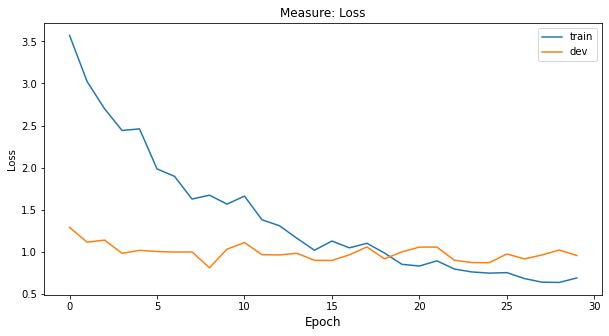

In [56]:
plot_statistics('Loss', losses)

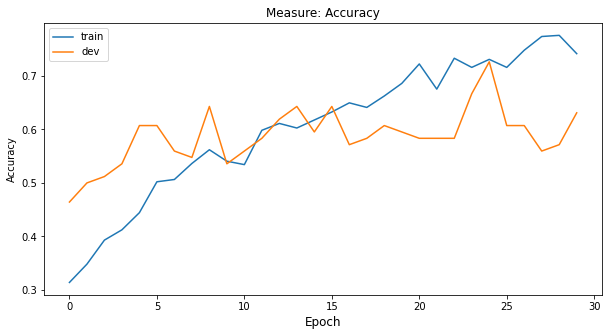

In [57]:
plot_statistics('Accuracy', accuracies)

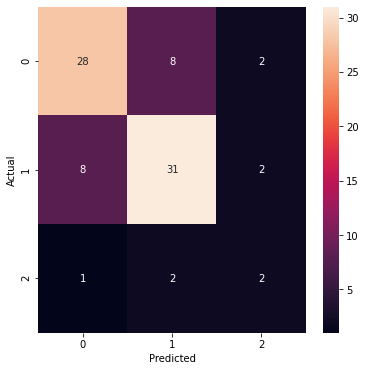

In [58]:
plot_cm(np.array(dev_labels), np.array(dev_preds))